# PV Forecasting con Temporal Fusion Transformer (TFT)
## Previsione Produzione Fotovoltaica 24h con Hyperparameter Optimization

### 🎯 Obiettivo
Previsione della produzione fotovoltaica a **24 ore** utilizzando **Temporal Fusion Transformer** con:
- ✅ **Temporal Cross-Validation** (5 fold, no data leakage)
- ✅ **Hyperparameter Tuning** con Optuna (Bayesian Optimization)
- ✅ **Training del modello finale** con best configuration
- ✅ **Salvataggio automatico** del modello e risultati

### 📋 Pipeline Completa
1. **Data Loading & Preprocessing** (CSV merge, missing values, features)
2. **Temporal Cross-Validation Setup** (5 fold temporali bilanciati)
3. **Hyperparameter Search** con Optuna (TPE Sampler)
4. **Final Model Training** (150 epochs con early stopping)
5. **Evaluation & Visualization** (metriche, plot, interpretabilità)
6. **Model Saving** (checkpoint + hyperparameters + report)

### ⚙️ Configurazione
- **Encoder**: 168 ore (1 settimana di contesto)
- **Decoder**: 24 ore (previsione giorno successivo)
- **Cross-Validation**: 5 fold temporali (80% train / 20% val per fold)
- **Hyperparameter Trials**: Configurabile (default: 20 trials)
- **GPU**: RTX 4060 (8GB) con CUDA 11.8

---

## 1. Import Librerie

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('seaborn-v0_8-darkgrid')

# PyTorch & PyTorch Lightning
import torch
# Import from both packages to ensure compatibility
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

# PyTorch Forecasting
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, QuantileLoss
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, RMSE, SMAPE

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Hyperparameter Optimization
import optuna
from optuna.integration import PyTorchLightningPruningCallback
import json
import time
import gc

print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pl.__version__}")
print(f"Optuna version: {optuna.__version__}")
print(f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

PyTorch version: 2.7.1+cu118
PyTorch Lightning version: 2.5.6
Device: NVIDIA GeForce RTX 4060


### Verifica GPU/CUDA

Verifichiamo se la GPU è disponibile e correttamente configurata con CUDA 11.8

In [2]:
import torch

print("="*60)
print("VERIFICA CONFIGURAZIONE GPU/CUDA")
print("="*60)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA disponibile: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Numero GPU disponibili: {torch.cuda.device_count()}")
    print(f"GPU attiva: {torch.cuda.current_device()}")
    print(f"Nome GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memoria GPU totale: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    
    # Test rapido
    x = torch.randn(3, 3).cuda()
    print(f"\n✓ Test GPU riuscito! Tensor creato su: {x.device}")
else:
    print("\n⚠️  GPU non disponibile. Possibili cause:")
    print("  1. Driver NVIDIA non installati o non aggiornati")
    print("  2. GPU non compatibile con CUDA 11.8")
    print("  3. Ambiente virtuale non configurato correttamente")
    print("\nPer verificare GPU hardware, esegui: nvidia-smi")

print("="*60)

VERIFICA CONFIGURAZIONE GPU/CUDA
PyTorch version: 2.7.1+cu118
CUDA disponibile: True
CUDA version: 11.8
Numero GPU disponibili: 1
GPU attiva: 0
Nome GPU: NVIDIA GeForce RTX 4060
Memoria GPU totale: 8.00 GB

✓ Test GPU riuscito! Tensor creato su: cuda:0


## 2. Data Loading & Merging

Carichiamo i 4 file CSV:
- 2 file per dati PV (produzione fotovoltaica)
- 2 file per dati meteo

Poi li concateniamo e facciamo il merge

### 2.1 Conversione File Excel in CSV

Prima convertiamo i file Excel (con 2 fogli ciascuno) in 4 file CSV separati

In [3]:
import os
from pathlib import Path
import pandas as pd

# Percorsi dei file Excel
project_root = Path('..').resolve()
data_dir = project_root / 'data' / 'raw'

pv_excel_file = data_dir / 'pv_dataset.xlsx'
wx_excel_file = data_dir / 'wx_dataset.xlsx'

print("="*60)
print("CONVERSIONE FILE EXCEL IN CSV")
print("="*60)

# Funzione per convertire Excel con 2 fogli in 2 CSV
def excel_to_csv(excel_path, base_name):
    """
    Converte un file Excel con 2 fogli in 2 file CSV separati
    
    Args:
        excel_path: Path al file Excel
        base_name: Nome base per i file CSV di output
    """
    if not excel_path.exists():
        print(f"✗ File non trovato: {excel_path}")
        return None, None
    
    print(f"\n Elaborazione: {excel_path.name}")
    
    # Leggi i nomi dei fogli
    xl_file = pd.ExcelFile(excel_path)
    sheet_names = xl_file.sheet_names
    
    print(f"   Fogli trovati ({len(sheet_names)}): {sheet_names}")
    
    if len(sheet_names) < 2:
        print(f"  Attenzione: trovati solo {len(sheet_names)} fogli invece di 2")
    
    csv_files = []
    
    # Converti ogni foglio in CSV
    for i, sheet_name in enumerate(sheet_names[:2]):  # Prendi solo i primi 2 fogli
        # Leggi il foglio
        df = pd.read_excel(excel_path, sheet_name=sheet_name)
        
        # Crea il nome del file CSV
        # Usa il nome del foglio per creare il CSV
        csv_filename = f"{base_name} - {sheet_name}.csv"
        csv_path = data_dir / csv_filename
        
        # Salva come CSV
        df.to_csv(csv_path, index=False)
        csv_files.append(csv_path)
        
        print(f"   ✓ Foglio '{sheet_name}' -> {csv_filename}")
        print(f"      Shape: {df.shape}, Colonne: {df.columns.tolist()}")
    
    return csv_files[0] if len(csv_files) > 0 else None, csv_files[1] if len(csv_files) > 1 else None

# Converti i file PV
print("\n" + "-"*60)
print("1. CONVERSIONE PV DATASET")
print("-"*60)
pv_csv1, pv_csv2 = excel_to_csv(pv_excel_file, "pv_dataset")

# Converti i file Weather
print("\n" + "-"*60)
print("2. CONVERSIONE WEATHER DATASET")
print("-"*60)
wx_csv1, wx_csv2 = excel_to_csv(wx_excel_file, "wx_dataset")

print("\n" + "="*60)
print("CONVERSIONE COMPLETATA!")
print("="*60)

# Verifica che tutti i file siano stati creati
all_files_created = all([pv_csv1, pv_csv2, wx_csv1, wx_csv2])

if all_files_created:
    print("\n✓ Tutti i 4 file CSV sono stati creati con successo:")
    print(f"  1. {pv_csv1.name}")
    print(f"  2. {pv_csv2.name}")
    print(f"  3. {wx_csv1.name}")
    print(f"  4. {wx_csv2.name}")
    print(f"\n📂 Salvati in: {data_dir}")
else:
    print("\n⚠️  Alcuni file non sono stati creati correttamente")
    
print("\n💡 Nota: I file CSV mantengono i nomi originali dei fogli Excel")

CONVERSIONE FILE EXCEL IN CSV

------------------------------------------------------------
1. CONVERSIONE PV DATASET
------------------------------------------------------------

 Elaborazione: pv_dataset.xlsx
   Fogli trovati (2): ['07-10--06-11', '07-11--06-12']
   Fogli trovati (2): ['07-10--06-11', '07-11--06-12']
   ✓ Foglio '07-10--06-11' -> pv_dataset - 07-10--06-11.csv
      Shape: (8760, 2), Colonne: ['Max kWp', 82.41]
   ✓ Foglio '07-10--06-11' -> pv_dataset - 07-10--06-11.csv
      Shape: (8760, 2), Colonne: ['Max kWp', 82.41]
   ✓ Foglio '07-11--06-12' -> pv_dataset - 07-11--06-12.csv
      Shape: (8784, 2), Colonne: ['Max kWp', 82.41]

------------------------------------------------------------
2. CONVERSIONE WEATHER DATASET
------------------------------------------------------------

 Elaborazione: wx_dataset.xlsx
   Fogli trovati (2): ['07-10--06-11', '07-11--06-12']
   ✓ Foglio '07-11--06-12' -> pv_dataset - 07-11--06-12.csv
      Shape: (8784, 2), Colonne: ['Max kWp

### 2.2 Caricamento CSV e Preparazione Dati

In [4]:
# Verifica la struttura delle directory e trova i file CSV
import os
from pathlib import Path

print("Current working directory:", os.getcwd())
print("\nFile nel notebook directory (src/):")
if os.path.exists('.'):
    for item in os.listdir('.'):
        print(f"  - {item}")

print("\nFile nella directory parent:")
parent_dir = Path('..').resolve()
if parent_dir.exists():
    for item in os.listdir(parent_dir):
        print(f"  - {item}")

# Cerca i file CSV
print("\n" + "="*60)
print("Ricerca file CSV...")
print("="*60)
for root, dirs, files in os.walk('..'):
    for file in files:
        if file.endswith('.csv'):
            full_path = os.path.join(root, file)
            print(f"Trovato: {full_path}")

Current working directory: d:\Cartelle\Cartelle nuove\Uni.Ingegneria\Magistrale UCBM\Deep Learning\DL-Project---24-Hour-Ahead-Power-Forecasting-with-Temporal-Fusion-Transformer-TFT-\src

File nel notebook directory (src/):
  - lightning_logs
  - PV_Forecasting_TFT.ipynb
  - tft_predictions.csv
  - tft_results.json

File nella directory parent:
  - .git
  - CHANGELOG_AND_FIXES.md
  - data
  - DEVELOPMENT_LOG.md
  - README.md
  - requirements.txt
  - SPIEGAZIONE_CODICE_NOTEBOOK.md
  - src
  - venv

Ricerca file CSV...
Trovato: ..\data\raw\pv_dataset - 07-10--06-11.csv
Trovato: ..\data\raw\pv_dataset - 07-11--06-12.csv
Trovato: ..\data\raw\wx_dataset - 07-10--06-11.csv
Trovato: ..\data\raw\wx_dataset - 07-11--06-12.csv
Trovato: ..\src\tft_predictions.csv
Trovato: ..\venv\Lib\site-packages\matplotlib\mpl-data\sample_data\data_x_x2_x3.csv
Trovato: ..\venv\Lib\site-packages\matplotlib\mpl-data\sample_data\msft.csv
Trovato: ..\venv\Lib\site-packages\matplotlib\mpl-data\sample_data\Stocks.csv


In [5]:
import os
from pathlib import Path

# Trova la directory root del progetto (una cartella sopra src/)
project_root = Path('..').resolve()

# Percorsi dei file - cerca prima nella directory data/, poi nella root
def find_csv_file(filename):
    """Cerca il file CSV in diverse possibili location"""
    possible_paths = [
        project_root / 'data' / 'raw' / filename,
        project_root / 'data' / filename,
        project_root / filename,
        Path('.') / filename,
        Path('..') / filename
    ]
    
    for path in possible_paths:
        if path.exists():
            print(f"✓ Trovato: {path}")
            return str(path)
    
    print(f"✗ Non trovato: {filename}")
    print(f"  Percorsi cercati:")
    for p in possible_paths:
        print(f"    - {p}")
    return None

print("Ricerca dei file CSV...\n")
pv_file1 = find_csv_file("pv_dataset - 07-10--06-11.csv")
pv_file2 = find_csv_file("pv_dataset - 07-11--06-12.csv")
wx_file1 = find_csv_file("wx_dataset - 07-10--06-11.csv")
wx_file2 = find_csv_file("wx_dataset - 07-11--06-12.csv")

# Verifica che tutti i file siano stati trovati
if not all([pv_file1, pv_file2, wx_file1, wx_file2]):
    print("\nATTENZIONE: Non tutti i file sono stati trovati!")
    print("\nAssicurati che i 4 file CSV siano nella directory del progetto.")
    print("Posizionali in una di queste location:")
    print(f"  - {project_root / 'data' / 'raw'}")
    print(f"  - {project_root / 'data'}")
    print(f"  - {project_root}")
    raise FileNotFoundError("File CSV non trovati")

print("\n" + "="*60)
print("Caricamento dati PV...")
print("="*60)

# Carica dati PV
pv1 = pd.read_csv(pv_file1)
pv2 = pd.read_csv(pv_file2)

print(f"PV1 shape: {pv1.shape}")
print(f"PV2 shape: {pv2.shape}")
print(f"\nColonne PV1: {pv1.columns.tolist()}")

# Concatena i dati PV
pv_data = pd.concat([pv1, pv2], ignore_index=True)
print(f"\nPV data concatenato: {pv_data.shape}")

# Identifica la colonna timestamp e target
# La colonna "Max kWp" contiene il timestamp
# La prima colonna numerica (probabilmente "82.41" o simile) è la produzione
timestamp_col = "Max kWp"
target_col = [col for col in pv_data.columns if col != timestamp_col][0]

print(f"\nColonna timestamp identificata: '{timestamp_col}'")
print(f"Colonna target identificata: '{target_col}'")

# Rinomina le colonne
pv_data = pv_data.rename(columns={timestamp_col: 'datetime', target_col: 'power_kw'})
print(f"\nPrime righe PV data:")
print(pv_data.head())

Ricerca dei file CSV...

✓ Trovato: D:\Cartelle\Cartelle nuove\Uni.Ingegneria\Magistrale UCBM\Deep Learning\DL-Project---24-Hour-Ahead-Power-Forecasting-with-Temporal-Fusion-Transformer-TFT-\data\raw\pv_dataset - 07-10--06-11.csv
✓ Trovato: D:\Cartelle\Cartelle nuove\Uni.Ingegneria\Magistrale UCBM\Deep Learning\DL-Project---24-Hour-Ahead-Power-Forecasting-with-Temporal-Fusion-Transformer-TFT-\data\raw\pv_dataset - 07-11--06-12.csv
✓ Trovato: D:\Cartelle\Cartelle nuove\Uni.Ingegneria\Magistrale UCBM\Deep Learning\DL-Project---24-Hour-Ahead-Power-Forecasting-with-Temporal-Fusion-Transformer-TFT-\data\raw\wx_dataset - 07-10--06-11.csv
✓ Trovato: D:\Cartelle\Cartelle nuove\Uni.Ingegneria\Magistrale UCBM\Deep Learning\DL-Project---24-Hour-Ahead-Power-Forecasting-with-Temporal-Fusion-Transformer-TFT-\data\raw\wx_dataset - 07-11--06-12.csv

Caricamento dati PV...
PV1 shape: (8760, 2)
PV2 shape: (8784, 2)

Colonne PV1: ['Max kWp', '82.41']

PV data concatenato: (17544, 2)

Colonna timestamp id

In [6]:
print("Caricamento dati meteo...")
# Carica dati meteo
wx1 = pd.read_csv(wx_file1)
wx2 = pd.read_csv(wx_file2)

print(f"WX1 shape: {wx1.shape}")
print(f"WX2 shape: {wx2.shape}")
print(f"\nColonne WX1: {wx1.columns.tolist()}")

# Concatena i dati meteo
wx_data = pd.concat([wx1, wx2], ignore_index=True)
print(f"\nWX data concatenato: {wx_data.shape}")

# Rinomina la colonna timestamp
wx_data = wx_data.rename(columns={'dt_iso': 'datetime'})
print(f"\nPrime righe WX data:")
print(wx_data.head())

Caricamento dati meteo...
WX1 shape: (8760, 15)
WX2 shape: (8784, 15)

Colonne WX1: ['dt_iso', 'lat', 'lon', 'temp', 'dew_point', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'clouds_all', 'weather_description', 'Dhi', 'Dni', 'Ghi']

WX data concatenato: (17544, 15)

Prime righe WX data:
                    datetime        lat         lon    temp  dew_point  \
0  2010-07-01 00:00:00+10:00 -32.951195  151.715443  281.66     276.31   
1  2010-07-01 01:00:00+10:00 -32.951195  151.715443  281.52     277.54   
2  2010-07-01 02:00:00+10:00 -32.951195  151.715443  280.92     277.15   
3  2010-07-01 03:00:00+10:00 -32.951195  151.715443  281.06     274.89   
4  2010-07-01 04:00:00+10:00 -32.951195  151.715443  280.93     277.34   

   pressure  humidity  wind_speed  wind_deg  rain_1h  clouds_all  \
0      1023        69        5.10       300      NaN          48   
1      1023        76        4.56       291      NaN          54   
2      1023        77        4.45       289   

In [7]:
print("Conversione timestamp e merging...")

# Converti timestamp in datetime e gestisci timezone
# Usa format='mixed' per gestire formati inconsistenti (con/senza microsecondi)
pv_data['datetime'] = pd.to_datetime(pv_data['datetime'], format='mixed', utc=True).dt.tz_localize(None)
wx_data['datetime'] = pd.to_datetime(wx_data['datetime'], format='mixed', utc=True).dt.tz_localize(None)

print(f"\nRange temporale PV: {pv_data['datetime'].min()} to {pv_data['datetime'].max()}")
print(f"Range temporale WX: {wx_data['datetime'].min()} to {wx_data['datetime'].max()}")

# Rimuovi duplicati temporali
pv_data = pv_data.drop_duplicates(subset=['datetime'], keep='first')
wx_data = wx_data.drop_duplicates(subset=['datetime'], keep='first')

print(f"\nDopo rimozione duplicati:")
print(f"PV data shape: {pv_data.shape}")
print(f"WX data shape: {wx_data.shape}")

# Merge dei dataset
data = pd.merge(pv_data, wx_data, on='datetime', how='inner')
print(f"\nDataset merged shape: {data.shape}")
print(f"\nColonne finali: {data.columns.tolist()}")

# Ordina per timestamp
data = data.sort_values('datetime').reset_index(drop=True)

print(f"\nPrime righe del dataset unificato:")
print(data.head(10))

Conversione timestamp e merging...

Range temporale PV: 2010-07-01 00:00:00 to 2012-06-30 23:00:00
Range temporale WX: 2010-06-30 14:00:00 to 2012-06-30 13:00:00

Dopo rimozione duplicati:
PV data shape: (17544, 2)
WX data shape: (17544, 15)

Dataset merged shape: (17317, 16)

Colonne finali: ['datetime', 'power_kw', 'lat', 'lon', 'temp', 'dew_point', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'clouds_all', 'weather_description', 'Dhi', 'Dni', 'Ghi']

Prime righe del dataset unificato:
             datetime  power_kw        lat         lon    temp  dew_point  \
0 2010-07-01 00:00:00     0.000 -32.951195  151.715443  281.67     275.26   
1 2010-07-01 01:00:00     0.000 -32.951195  151.715443  284.87     277.84   
2 2010-07-01 02:00:00     0.000 -32.951195  151.715443  287.90     276.71   
3 2010-07-05 04:00:00     0.000 -32.951195  151.715443  287.60     284.75   
4 2010-07-10 05:00:00     0.000 -32.951195  151.715443  289.75     285.71   
5 2010-07-10 06:00:00     0.0

## 3. Data Analysis & Missing Values

In [8]:
print("Analisi dei dati...\n")
print(f"Dimensione dataset: {data.shape}")
print(f"\nInfo dataset:")
print(data.info())

print("\n" + "="*50)
print("STATISTICHE DESCRITTIVE")
print("="*50)
print(data.describe())

Analisi dei dati...

Dimensione dataset: (17317, 16)

Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17317 entries, 0 to 17316
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             17317 non-null  datetime64[ns]
 1   power_kw             17317 non-null  float64       
 2   lat                  17317 non-null  float64       
 3   lon                  17317 non-null  float64       
 4   temp                 17317 non-null  float64       
 5   dew_point            17317 non-null  float64       
 6   pressure             17317 non-null  int64         
 7   humidity             17317 non-null  int64         
 8   wind_speed           17317 non-null  float64       
 9   wind_deg             17317 non-null  int64         
 10  rain_1h              3659 non-null   float64       
 11  clouds_all           17317 non-null  int64         
 12  weather_description 

In [9]:
print("Controllo valori mancanti...\n")
missing = data.isnull().sum()
missing_pct = (missing / len(data)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_df) > 0:
    print("Colonne con valori mancanti:")
    print(missing_df)
else:
    print("Nessun valore mancante trovato!")

Controllo valori mancanti...

Colonne con valori mancanti:
         Missing Count  Percentage
rain_1h          13658   78.870474


In [10]:
print("Gestione valori mancanti...\n")

# rain_1h: NaN = 0 (nessuna pioggia)
if 'rain_1h' in data.columns:
    data['rain_1h'] = data['rain_1h'].fillna(0)
    print("✓ rain_1h: NaN sostituiti con 0")

# Per le altre colonne numeriche: interpolazione lineare limitata
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
if 'power_kw' in numeric_cols:
    # Interpolazione lineare con limite di 3 valori consecutivi
    data['power_kw'] = data['power_kw'].interpolate(method='linear', limit=3)
    # Forward fill per eventuali gap rimanenti
    data['power_kw'] = data['power_kw'].fillna(method='ffill', limit=1)
    print("✓ power_kw: interpolazione lineare applicata")

# Altre colonne meteo
for col in numeric_cols:
    if col != 'power_kw' and data[col].isnull().sum() > 0:
        data[col] = data[col].interpolate(method='linear', limit=5)
        data[col] = data[col].fillna(method='ffill', limit=2)
        print(f"✓ {col}: interpolazione applicata")

# Rimuovi righe con NaN rimanenti (se presenti)
rows_before = len(data)
data = data.dropna()
rows_after = len(data)
print(f"\nRighe rimosse: {rows_before - rows_after}")
print(f"Dataset finale: {data.shape}")

print("\n✓ Gestione valori mancanti completata!")

Gestione valori mancanti...

✓ rain_1h: NaN sostituiti con 0
✓ power_kw: interpolazione lineare applicata

Righe rimosse: 0
Dataset finale: (17317, 16)

✓ Gestione valori mancanti completata!


## 4. Feature Engineering

In [11]:
print("Feature Engineering...\n")

# Feature temporali
data['hour'] = data['datetime'].dt.hour
data['day_of_month'] = data['datetime'].dt.day
data['month'] = data['datetime'].dt.month
data['day_of_week'] = data['datetime'].dt.dayofweek

print("✓ Feature temporali create: hour, day_of_month, month, day_of_week")

# Group ID (necessario per TFT)
data['group_id'] = 'PV1'
print("✓ group_id creato: 'PV1'")

# Time index (indice temporale incrementale) - DEVE essere intero
data['time_idx'] = np.arange(len(data)).astype(int)
print("✓ time_idx creato: 0 to", len(data)-1)

# Converti tutte le colonne numeriche in float32 (ECCETTO time_idx che deve rimanere int)
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    if col != 'time_idx':  # Non convertire time_idx
        data[col] = data[col].astype(np.float32)

print(f"✓ {len(numeric_cols)-1} colonne numeriche convertite in float32")
print(f"✓ time_idx mantenuto come {data['time_idx'].dtype}")

print("\n" + "="*50)
print("DATASET FINALE")
print("="*50)
print(f"Shape: {data.shape}")
print(f"\nColonne: {data.columns.tolist()}")
print(f"\nPrime righe:")
print(data.head())

Feature Engineering...

✓ Feature temporali create: hour, day_of_month, month, day_of_week
✓ group_id creato: 'PV1'
✓ time_idx creato: 0 to 17316
✓ 18 colonne numeriche convertite in float32
✓ time_idx mantenuto come int64

DATASET FINALE
Shape: (17317, 22)

Colonne: ['datetime', 'power_kw', 'lat', 'lon', 'temp', 'dew_point', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'clouds_all', 'weather_description', 'Dhi', 'Dni', 'Ghi', 'hour', 'day_of_month', 'month', 'day_of_week', 'group_id', 'time_idx']

Prime righe:
             datetime  power_kw        lat         lon        temp  \
0 2010-07-01 00:00:00       0.0 -32.951195  151.715439  281.670013   
1 2010-07-01 01:00:00       0.0 -32.951195  151.715439  284.869995   
2 2010-07-01 02:00:00       0.0 -32.951195  151.715439  287.899994   
3 2010-07-05 04:00:00       0.0 -32.951195  151.715439  287.600006   
4 2010-07-10 05:00:00       0.0 -32.951195  151.715439  289.750000   

    dew_point  pressure  humidity  wind_speed 

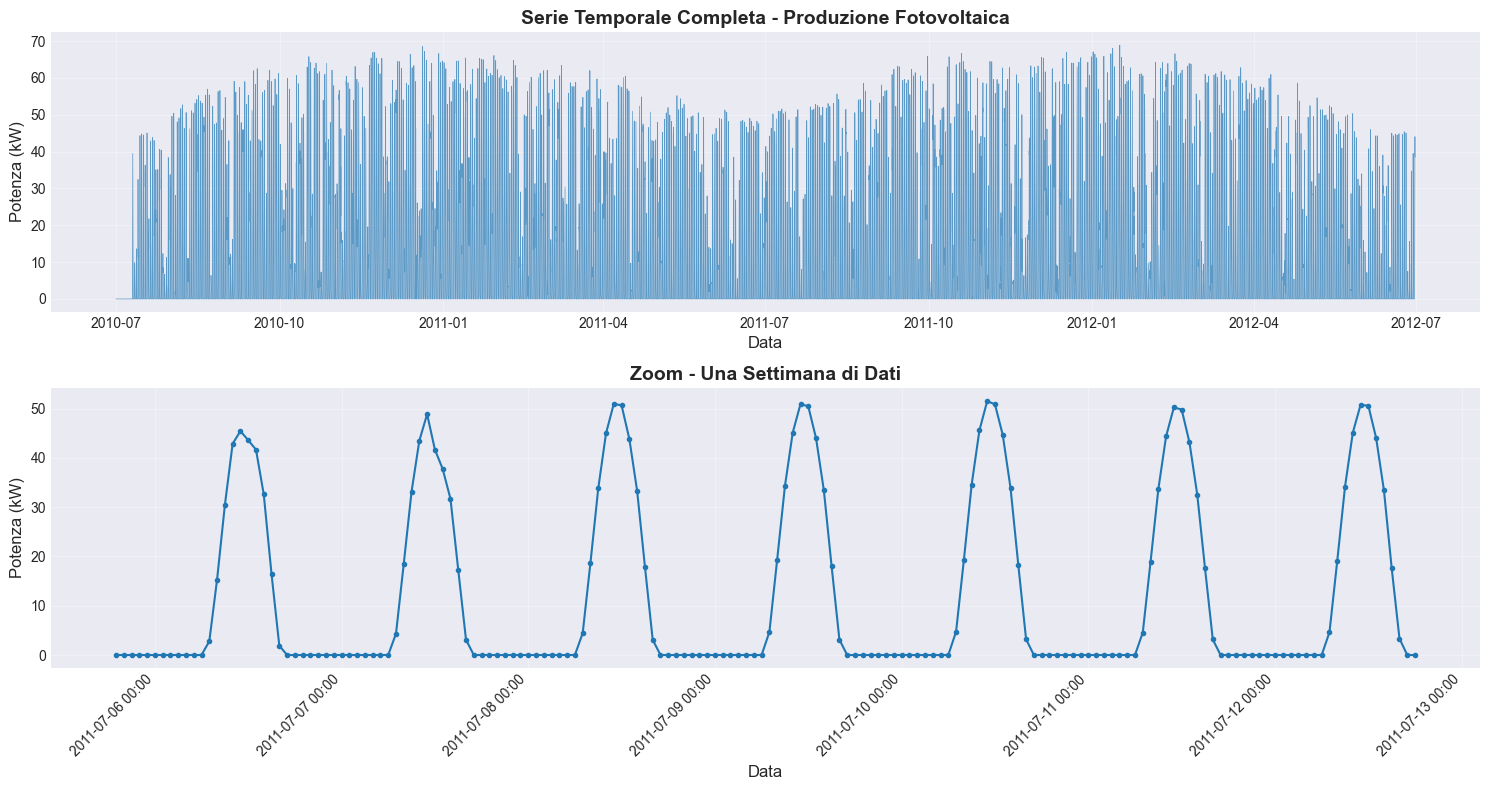


Statistiche produzione:
Media: 12.53 kW
Max: 68.92 kW
Min: 0.00 kW
Std: 18.55 kW


In [12]:
# Visualizzazione della serie temporale target
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Serie completa
axes[0].plot(data['datetime'], data['power_kw'], linewidth=0.5, alpha=0.7)
axes[0].set_title('Serie Temporale Completa - Produzione Fotovoltaica', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Data', fontsize=12)
axes[0].set_ylabel('Potenza (kW)', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Zoom su una settimana
sample_start = len(data) // 2
sample_end = sample_start + 168  # 1 settimana
axes[1].plot(data['datetime'].iloc[sample_start:sample_end], 
             data['power_kw'].iloc[sample_start:sample_end], 
             linewidth=1.5, marker='o', markersize=3)
axes[1].set_title('Zoom - Una Settimana di Dati', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Data', fontsize=12)
axes[1].set_ylabel('Potenza (kW)', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print(f"\nStatistiche produzione:")
print(f"Media: {data['power_kw'].mean():.2f} kW")
print(f"Max: {data['power_kw'].max():.2f} kW")
print(f"Min: {data['power_kw'].min():.2f} kW")
print(f"Std: {data['power_kw'].std():.2f} kW")

## 5. Pre-processing per TFT (TimeSeriesDataSet)

Configuriamo il TimeSeriesDataSet per l'architettura TFT:
- **Encoder**: 168 ore (1 settimana di storico)
- **Decoder**: 24 ore (previsione giorno successivo)

In [ ]:
# Parametri TFT - Fissi per tutto il tuning
MAX_ENCODER_LENGTH = 168  # 1 settimana di contesto
MAX_PREDICTION_LENGTH = 24  # Previsione 24 ore

def setup_temporal_cross_validation(data, n_folds=5, val_ratio=0.2):
    """
    Temporal Cross-Validation con fold bilanciati per evitare data leakage
    
    Args:
        data: Dataset completo
        n_folds: Numero di fold temporali
        val_ratio: Percentuale fissa per validation set (es. 0.2 = 20%)
    
    Returns:
        list: Lista di tuple (train_data, val_data) per ogni fold
    """
    print("="*70)
    print("TEMPORAL CROSS-VALIDATION SETUP")
    print("="*70)
    
    max_time_idx = data['time_idx'].max()
    total_samples = len(data)
    val_size = int(total_samples * val_ratio)  # Validation set fisso (20%)
    folds = []
    
    print(f"Dataset totale: {total_samples} samples")
    print(f"Validation size fisso: {val_size} samples ({val_ratio*100:.1f}%)")
    
    # Calcola la dimensione incrementale per il training set
    min_train_size = int(total_samples * 0.5)  # Minimo 50% per training
    max_train_size = total_samples - val_size  # Massimo possibile
    
    for fold in range(n_folds):
        # Training size cresce progressivamente
        progress = fold / (n_folds - 1) if n_folds > 1 else 0
        train_size = int(min_train_size + progress * (max_train_size - min_train_size))
        
        # Assicura che train + val non superi il dataset
        if train_size + val_size > total_samples:
            train_size = total_samples - val_size
            
        # Calcola cutoff temporali
        train_cutoff = train_size - 1
        val_start = train_cutoff + 1
        val_cutoff = val_start + val_size - 1
        
        # Assicura che non superi i limiti del dataset
        if val_cutoff >= max_time_idx:
            val_cutoff = max_time_idx
            val_start = val_cutoff - val_size + 1
            train_cutoff = val_start - 1
            
        # Skip se training set troppo piccolo
        if train_cutoff < MAX_ENCODER_LENGTH + MAX_PREDICTION_LENGTH:
            print(f"Skipping fold {fold + 1}: training set troppo piccolo")
            continue
            
        # Skip se validation set troppo piccolo
        if (val_cutoff - val_start + 1) < MAX_PREDICTION_LENGTH * 5:
            print(f"Skipping fold {fold + 1}: validation set troppo piccolo")
            continue
            
        train_data = data[data['time_idx'] <= train_cutoff].copy()
        val_data = data[(data['time_idx'] >= val_start) & (data['time_idx'] <= val_cutoff)].copy()
        
        folds.append((train_data, val_data))
        
        print(f"\nFold {fold + 1}/{n_folds}:")
        print(f"  Training: {len(train_data)} samples ({len(train_data)/total_samples*100:.1f}%)")
        print(f"  Validation: {len(val_data)} samples ({len(val_data)/total_samples*100:.1f}%)")
        print(f"  Train range: {train_data['datetime'].min()} to {train_data['datetime'].max()}")
        print(f"  Val range: {val_data['datetime'].min()} to {val_data['datetime'].max()}")
    
    print(f"\n✓ Creati {len(folds)} fold temporali validi")
    return folds

# Setup temporal cross-validation
folds = setup_temporal_cross_validation(data, n_folds=5, val_ratio=0.2)

print(f"\n✓ Cross-validation configurata con {len(folds)} fold")

Configurazione TimeSeriesDataSet:
  - Encoder length: 168 ore (1 settimana)
  - Prediction length: 24 ore (1 giorno)
  - Finestra totale: 192 ore

Split Train/Validation:
  - Training samples: 15157
  - Validation samples: 2160
  - Training range: 2010-07-01 00:00:00 to 2012-04-01 13:00:00
  - Validation range: 2012-04-01 14:00:00 to 2012-06-30 13:00:00


### 5.1 Hyperparameter Search Space

Definizione dello spazio di ricerca per Optuna

In [ ]:
def suggest_hyperparameters(trial):
    """
    Definisce lo spazio di ricerca degli iperparametri per Optuna
    """
    hyperparams = {
        # Architettura del modello
        'hidden_size': trial.suggest_categorical('hidden_size', [64, 128, 192, 256]),
        'lstm_layers': trial.suggest_int('lstm_layers', 1, 3),
        'attention_head_size': trial.suggest_categorical('attention_head_size', [1, 2, 4, 8]),
        'hidden_continuous_size': trial.suggest_categorical('hidden_continuous_size', [8, 16, 32]),
        
        # Regolarizzazione
        'dropout': trial.suggest_float('dropout', 0.1, 0.4),
        
        # Training parameters
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
        
        # Early stopping patience
        'patience': trial.suggest_int('patience', 10, 30),
        
        # Gradient clipping
        'gradient_clip_val': trial.suggest_float('gradient_clip_val', 0.1, 2.0),
    }
    
    return hyperparams

print("="*70)
print("HYPERPARAMETER SEARCH SPACE")
print("="*70)
print("  - hidden_size: [64, 128, 192, 256]")
print("  - lstm_layers: [1, 2, 3]")
print("  - attention_head_size: [1, 2, 4, 8]")
print("  - hidden_continuous_size: [8, 16, 32]")
print("  - dropout: [0.1, 0.4]")
print("  - learning_rate: [1e-4, 1e-1] (log)")
print("  - batch_size: [32, 64, 128]")
print("  - patience: [10, 30]")
print("  - gradient_clip_val: [0.1, 2.0]")
print("="*70)

### 5.2 Objective Function con Cross-Validation

Funzione obiettivo che valuta gli iperparametri su tutti i fold

In [ ]:
def objective(trial):
    """
    Funzione obiettivo per Optuna con temporal cross-validation
    Valuta gli iperparametri su tutti i fold e restituisce la media
    """
    # Define known_reals - time-varying known features
    known_reals = [
        "time_idx",       # Always required
        "hour",           # Time of day  
        "day_of_month",   # Day of month
        "month",          # Month of year
        "day_of_week",    # Day of week
    ]
    
    # Suggest hyperparameters
    hyperparams = suggest_hyperparameters(trial)
    
    try:
        print(f"\n{'='*60}")
        print(f"TRIAL {trial.number} - CROSS-VALIDATION")
        print(f"{'='*60}")
        print("Hyperparameters:")
        for key, value in hyperparams.items():
            print(f"  {key}: {value}")
        
        fold_losses = []
        
        # Loop attraverso tutti i fold per cross-validation
        for fold_idx, (train_data, val_data) in enumerate(folds):
            print(f"\n--- Fold {fold_idx + 1}/{len(folds)} ---")
            
            # Crea TimeSeriesDataSet per questo fold
            training_dataset = TimeSeriesDataSet(
                train_data,
                time_idx="time_idx",
                target="power_kw",
                group_ids=["group_id"],
                min_encoder_length=MAX_ENCODER_LENGTH,
                max_encoder_length=MAX_ENCODER_LENGTH,
                min_prediction_length=MAX_PREDICTION_LENGTH,
                max_prediction_length=MAX_PREDICTION_LENGTH,
                static_categoricals=["group_id"],
                time_varying_known_reals=known_reals,
                time_varying_unknown_reals=["power_kw"],
                target_normalizer=GroupNormalizer(
                    groups=["group_id"], 
                    transformation=None
                ),
                add_relative_time_idx=True,
                add_target_scales=True,
                add_encoder_length=True,
            )
            
            # Validation dataset per questo fold
            fold_data = pd.concat([train_data, val_data]).sort_values('time_idx')
            validation_dataset = TimeSeriesDataSet.from_dataset(
                training_dataset, 
                fold_data,
                predict=True, 
                stop_randomization=True
            )
            
            # DataLoaders per questo fold
            train_dataloader = training_dataset.to_dataloader(
                train=True, 
                batch_size=hyperparams['batch_size'], 
                num_workers=0
            )
            
            val_dataloader = validation_dataset.to_dataloader(
                train=False, 
                batch_size=hyperparams['batch_size'] * 2, 
                num_workers=0
            )
            
            # Crea modello TFT per questo fold
            tft = TemporalFusionTransformer.from_dataset(
                training_dataset,
                learning_rate=hyperparams['learning_rate'],
                hidden_size=hyperparams['hidden_size'],
                lstm_layers=hyperparams['lstm_layers'],
                attention_head_size=hyperparams['attention_head_size'],
                dropout=hyperparams['dropout'],
                hidden_continuous_size=hyperparams['hidden_continuous_size'],
                output_size=7,
                loss=QuantileLoss(),
                log_interval=10,
                reduce_on_plateau_patience=4,
            )
            
            # Callbacks per questo fold
            early_stop_callback = EarlyStopping(
                monitor="val_loss",
                min_delta=1e-4,
                patience=max(5, hyperparams['patience'] // 2),  # Patience ridotta per fold
                verbose=False,
                mode="min"
            )
            
            # Trainer per questo fold
            trainer = pl.Trainer(
                max_epochs=30,  # Epochs ridotte per fold multiple
                accelerator="auto",
                devices=1,
                gradient_clip_val=hyperparams['gradient_clip_val'],
                callbacks=[early_stop_callback],
                logger=False,
                enable_progress_bar=False,
                enable_model_summary=False,
                enable_checkpointing=False,
            )
            
            # Training su questo fold
            trainer.fit(
                tft,
                train_dataloaders=train_dataloader,
                val_dataloaders=val_dataloader,
            )
            
            # Ottieni validation loss per questo fold
            fold_val_loss = trainer.callback_metrics.get("val_loss")
            
            if fold_val_loss is None:
                fold_val_loss = float('inf')
            else:
                fold_val_loss = fold_val_loss.item()
            
            fold_losses.append(fold_val_loss)
            print(f"Fold {fold_idx + 1} Val Loss: {fold_val_loss:.6f}")
            
            # Cleanup memoria per questo fold
            del tft, trainer, training_dataset, validation_dataset
            del train_dataloader, val_dataloader
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
            gc.collect()
        
        # Calcola media validation loss su tutti i fold
        mean_val_loss = np.mean(fold_losses)
        std_val_loss = np.std(fold_losses)
        
        print(f"\n📊 Trial {trial.number} RISULTATI:")
        print(f"  Mean Val Loss: {mean_val_loss:.6f} (±{std_val_loss:.6f})")
        
        # Per Optuna pruning
        for fold_idx, loss in enumerate(fold_losses):
            trial.report(loss, fold_idx)
            if trial.should_prune():
                print(f"  ⚡ Trial pruned at fold {fold_idx + 1}")
                raise optuna.exceptions.TrialPruned()
        
        return mean_val_loss
        
    except Exception as e:
        print(f"Trial {trial.number} FAILED: {str(e)}")
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        gc.collect()
        return float('inf')

print("✓ Funzione obiettivo definita con cross-validation")

### 5.3 Avvio Hyperparameter Optimization

Eseguiamo l'ottimizzazione con Optuna (modificare N_TRIALS secondo necessità)

In [ ]:
# Configurazione Optuna Study
N_TRIALS = 10  # Numero di trials per l'ottimizzazione  

print("="*70)
print("AVVIO HYPERPARAMETER TUNING")
print("="*70)
print(f"Numero di trials: {N_TRIALS}")
print(f"Numero di fold per trial: {len(folds)}")
print(f"Max epochs per fold: 30")
print(f"Algoritmo: TPE Sampler con Median Pruner")
print("="*70)

# Crea studio Optuna
study = optuna.create_study(
    direction="minimize",  # Minimizza validation loss
    study_name="tft_pv_forecasting",
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2)
)

# Avvia ottimizzazione
start_time = time.time()

study.optimize(
    objective, 
    n_trials=N_TRIALS,
    timeout=None,
    gc_after_trial=True,
    show_progress_bar=True
)

end_time = time.time()
duration = end_time - start_time

print("\n" + "="*70)
print("HYPERPARAMETER TUNING COMPLETATO!")
print("="*70)
print(f"Tempo totale: {duration/3600:.2f} ore ({duration/60:.1f} minuti)")
print(f"Trials completati: {len(study.trials)}")
print(f"Best trial: #{study.best_trial.number}")
print(f"Best validation loss: {study.best_value:.6f}")
print("="*70)

### 5.4 Analisi Risultati Optimization

In [ ]:
# Analisi dei risultati
print("="*70)
print("ANALISI RISULTATI HYPERPARAMETER TUNING")
print("="*70)

# Best trial
best_trial = study.best_trial
print(f"\n🏆 Best Trial #{best_trial.number}")
print(f"Best Validation Loss: {best_trial.value:.6f}")
print("\n📋 Best Hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

# Statistiche generali
completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
failed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.FAIL]
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]

print(f"\n" + "-"*70)
print("STATISTICHE GENERALI")
print("-"*70)
print(f"Trials completati: {len(completed_trials)}")
print(f"Trials falliti: {len(failed_trials)}")
print(f"Trials pruned: {len(pruned_trials)}")
print(f"Success rate: {len(completed_trials)/len(study.trials)*100:.1f}%")

if len(completed_trials) > 0:
    val_losses = [t.value for t in completed_trials]
    print(f"\nValidation Loss Statistics:")
    print(f"  Min: {min(val_losses):.6f}")
    print(f"  Max: {max(val_losses):.6f}")
    print(f"  Mean: {np.mean(val_losses):.6f}")
    print(f"  Std: {np.std(val_losses):.6f}")

# Top 5 trials
print("\n" + "-"*70)
print("TOP 5 TRIALS")
print("-"*70)
trials_df = study.trials_dataframe().sort_values('value')
top_5 = trials_df.head(5)

print(f"{'Rank':<5} {'Trial':<7} {'Val Loss':<12}")
print("-"*70)
for i, (_, row) in enumerate(top_5.iterrows(), 1):
    print(f"{i:<5} #{int(row['number']):<6} {row['value']:<12.6f}")

# Visualizzazione risultati
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Optimization History
completed_trials_values = [(t.number, t.value) for t in completed_trials]
if completed_trials_values:
    trial_numbers, values = zip(*completed_trials_values)
    axes[0, 0].plot(trial_numbers, values, 'o-', alpha=0.6, color='#2E86AB', linewidth=2, markersize=8)
    axes[0, 0].axhline(y=study.best_value, color='red', linestyle='--', linewidth=2, label=f'Best: {study.best_value:.4f}')
    axes[0, 0].set_xlabel('Trial Number', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Validation Loss', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Optimization History', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

# 2. Parameter Importance
try:
    importance = optuna.importance.get_param_importances(study)
    if importance:
        params, importances = zip(*list(importance.items())[:8])  # Top 8
        axes[0, 1].barh(params, importances, color='#A23B72', alpha=0.7)
        axes[0, 1].set_xlabel('Importance', fontsize=12, fontweight='bold')
        axes[0, 1].set_title('Parameter Importance', fontsize=14, fontweight='bold')
        axes[0, 1].grid(True, alpha=0.3, axis='x')
except:
    axes[0, 1].text(0.5, 0.5, 'Parameter Importance\nNot Available', 
                   ha='center', va='center', transform=axes[0, 1].transAxes, fontsize=12)

# 3. Learning Rate vs Validation Loss
if completed_trials:
    lr_values = [t.params.get('learning_rate', 0) for t in completed_trials]
    val_losses = [t.value for t in completed_trials]
    axes[1, 0].scatter(lr_values, val_losses, alpha=0.6, s=80, color='#2E86AB')
    axes[1, 0].set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Validation Loss', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Learning Rate vs Val Loss', fontsize=14, fontweight='bold')
    axes[1, 0].set_xscale('log')
    axes[1, 0].grid(True, alpha=0.3)

# 4. Hidden Size vs Validation Loss
if completed_trials:
    hidden_sizes = [t.params.get('hidden_size', 0) for t in completed_trials]
    axes[1, 1].scatter(hidden_sizes, val_losses, alpha=0.6, s=80, color='#A23B72')
    axes[1, 1].set_xlabel('Hidden Size', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Validation Loss', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Hidden Size vs Val Loss', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Salva study results
study_results = {
    'best_trial_number': best_trial.number,
    'best_validation_loss': best_trial.value,
    'best_params': best_trial.params,
    'n_trials': len(study.trials),
    'n_completed': len(completed_trials),
    'n_failed': len(failed_trials),
    'n_pruned': len(pruned_trials),
    'optimization_duration_hours': duration / 3600
}

with open('optuna_study_results.json', 'w') as f:
    json.dump(study_results, f, indent=4)

print(f"\n✓ Risultati salvati in 'optuna_study_results.json'")

## 6. Training Modello Finale con Best Hyperparameters

Trainiamo il modello finale usando gli iperparametri ottimali trovati da Optuna

In [ ]:
# Training del modello finale con i migliori iperparametri
print("="*70)
print("TRAINING MODELLO FINALE CON BEST HYPERPARAMETERS")
print("="*70)

# Define known_reals - time-varying known features
known_reals = [
    "time_idx",       # Always required
    "hour",           # Time of day  
    "day_of_month",   # Day of month
    "month",          # Month of year
    "day_of_week",    # Day of week
]

# Usa l'ultimo fold (più dati di training)
train_data, val_data = folds[-1]
best_params = study.best_trial.params

print(f"\nDataset utilizzato (ultimo fold):")
print(f"  Training: {len(train_data)} samples")
print(f"  Validation: {len(val_data)} samples")

print(f"\nBest Hyperparameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

# In alternativa utilizzo gli iperparametri scelti manualmente
# best_params = {
#     'hidden_size': 128,
#     'lstm_layers': 2,
#     'attention_head_size': 4,
#     'hidden_continuous_size': 16,
#     'dropout': 0.2,
#     'learning_rate': 0.001,
#     'batch_size': 64,
#     'patience': 20,
#     'gradient_clip_val': 0.5,
# }

# Crea TimeSeriesDataSet finale
training_dataset = TimeSeriesDataSet(
    train_data,
    time_idx="time_idx",
    target="power_kw",
    group_ids=["group_id"],
    min_encoder_length=MAX_ENCODER_LENGTH,
    max_encoder_length=MAX_ENCODER_LENGTH,
    min_prediction_length=MAX_PREDICTION_LENGTH,
    max_prediction_length=MAX_PREDICTION_LENGTH,
    static_categoricals=["group_id"],
    time_varying_known_reals=known_reals,
    time_varying_unknown_reals=["power_kw"],
    target_normalizer=GroupNormalizer(
        groups=["group_id"], 
        transformation=None
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# Validation dataset
full_fold_data = pd.concat([train_data, val_data]).sort_values('time_idx')
validation_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset, 
    full_fold_data,
    predict=True, 
    stop_randomization=True
)

# DataLoaders finali
train_dataloader = training_dataset.to_dataloader(
    train=True, 
    batch_size=best_params['batch_size'], 
    num_workers=0
)

val_dataloader = validation_dataset.to_dataloader(
    train=False, 
    batch_size=best_params['batch_size'] * 2, 
    num_workers=0
)

print(f"\n✓ Dataset creati:")
print(f"  - Training batches: {len(train_dataloader)}")
print(f"  - Validation batches: {len(val_dataloader)}")

# Crea modello TFT finale con best hyperparameters
tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=best_params['learning_rate'],
    hidden_size=best_params['hidden_size'],
    lstm_layers=best_params['lstm_layers'],
    attention_head_size=best_params['attention_head_size'],
    dropout=best_params['dropout'],
    hidden_continuous_size=best_params['hidden_continuous_size'],
    output_size=7,
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)

print(f"\n✓ Modello TFT creato con best hyperparameters")
print(f"Parametri totali: {sum(p.numel() for p in tft.parameters()):,}")
print(f"Parametri trainable: {sum(p.numel() for p in tft.parameters() if p.requires_grad):,}")

Configurazione Temporal Fusion Transformer...

✓ Temporal Fusion Transformer inizializzato

Configurazione modello (OTTIMIZZATA):
  - learning_rate: 0.01 (ridotto per stabilità)
  - hidden_size: 128 (ridotto per semplicità)
  - lstm_layers: 2 (semplificato)
  - attention_head_size: 4
  - dropout: 0.2 (aumentato per regolarizzazione)
  - hidden_continuous_size: 8 (ridotto)
  - output_size: 7
  - loss: QuantileLoss
  - learning_rate: 0.01

Parametri totali: 1,185,778
Parametri trainable: 1,185,778

Type del modello: <class 'pytorch_forecasting.models.temporal_fusion_transformer._tft.TemporalFusionTransformer'>
Module Resolution Order (MRO):
  - <class 'pytorch_forecasting.models.temporal_fusion_transformer._tft.TemporalFusionTransformer'>
  - <class 'pytorch_forecasting.models.base._base_model.BaseModelWithCovariates'>
  - <class 'pytorch_forecasting.models.base._base_model.BaseModel'>
  - <class 'pytorch_forecasting.utils._utils.InitialParameterRepresenterMixIn'>
  - <class 'lightning.p

## 7. Training del Modello Finale

Training completo con early stopping e monitoring

In [ ]:
# Configurazione callbacks per training finale
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=best_params['patience'],
    verbose=True,
    mode="min"
)

lr_monitor = LearningRateMonitor(logging_interval="epoch")

# Logger
logger = TensorBoardLogger("lightning_logs", name="best_tft_final_model")

print("✓ Callbacks configurati:")
print(f"  - EarlyStopping (patience={best_params['patience']})")
print("  - LearningRateMonitor")
print("  - TensorBoardLogger")

✓ Callbacks configurati:
  - EarlyStopping (patience=10)
  - LearningRateMonitor
  - TensorBoardLogger


In [ ]:
# Configurazione Trainer per modello finale
trainer = pl.Trainer(
    max_epochs=150,  # Più epochs per il modello finale
    accelerator="auto",
    devices=1,
    gradient_clip_val=best_params['gradient_clip_val'],
    callbacks=[early_stop_callback, lr_monitor],
    logger=logger,
    enable_progress_bar=True,
    log_every_n_steps=10,
)

print("\n" + "="*70)
print("INIZIO TRAINING MODELLO FINALE")
print("="*70)
print(f"Max epochs: {trainer.max_epochs}")
print(f"Gradient clip: {best_params['gradient_clip_val']}")
print(f"Batch size: {best_params['batch_size']}")
print(f"Learning rate: {best_params['learning_rate']:.6f}")
print(f"Accelerator: {trainer.accelerator}")
print(f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
print("="*70 + "\n")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



INIZIO TRAINING
Max epochs: 100
Accelerator: <lightning.pytorch.accelerators.cuda.CUDAAccelerator object at 0x0000022E28C881A0>
Device: NVIDIA GeForce RTX 4060



In [21]:
# TRAINING DEL MODELLO
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

print("\n" + "="*60)
print("TRAINING COMPLETATO!")
print("="*60)

You are using a CUDA device ('NVIDIA GeForce RTX 4060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1      | train
3  | prescalers                         | ModuleDict                      | 272    | train

Epoch 0: 100%|██████████| 233/233 [00:54<00:00,  4.29it/s, v_num=5, train_loss_step=1.480, val_loss=0.889, train_loss_epoch=2.430]

Metric val_loss improved. New best score: 0.889


Epoch 1: 100%|██████████| 233/233 [00:53<00:00,  4.38it/s, v_num=5, train_loss_step=1.300, val_loss=0.697, train_loss_epoch=1.360]

Metric val_loss improved by 0.192 >= min_delta = 0.0001. New best score: 0.697


Epoch 2: 100%|██████████| 233/233 [00:53<00:00,  4.37it/s, v_num=5, train_loss_step=1.050, val_loss=0.682, train_loss_epoch=1.120]

Metric val_loss improved by 0.016 >= min_delta = 0.0001. New best score: 0.682


Epoch 4: 100%|██████████| 233/233 [00:53<00:00,  4.39it/s, v_num=5, train_loss_step=0.882, val_loss=0.528, train_loss_epoch=0.895]

Metric val_loss improved by 0.154 >= min_delta = 0.0001. New best score: 0.528


Epoch 24: 100%|██████████| 233/233 [00:53<00:00,  4.36it/s, v_num=5, train_loss_step=0.298, val_loss=0.590, train_loss_epoch=0.289]

Monitored metric val_loss did not improve in the last 20 records. Best score: 0.528. Signaling Trainer to stop.


Epoch 24: 100%|██████████| 233/233 [00:53<00:00,  4.35it/s, v_num=5, train_loss_step=0.298, val_loss=0.590, train_loss_epoch=0.289]


TRAINING COMPLETATO!

TRAINING COMPLETATO!


## 8. Caricamento Best Model & Salvataggio

In [ ]:
# Define known_reals (same as in objective function)
known_reals = ["time_idx"]

# Carica il miglior modello dal checkpoint
best_model_path = trainer.checkpoint_callback.best_model_path
print(f"Caricamento miglior modello da: {best_model_path}")

best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
print("✓ Best model caricato con successo")

# Salva il modello finale in una directory dedicata
from pathlib import Path
import shutil

# Crea directory per il modello finale
model_save_dir = Path("final_best_model")
model_save_dir.mkdir(exist_ok=True)

# Copia il best checkpoint
final_model_path = model_save_dir / "best_tft_model.ckpt"
shutil.copy(best_model_path, final_model_path)

print(f"\n✓ Modello finale salvato in: {final_model_path}")

# Salva anche i migliori iperparametri
hyperparams_path = model_save_dir / "best_hyperparameters.json"
with open(hyperparams_path, 'w') as f:
    json.dump(best_params, f, indent=4)

print(f"✓ Hyperparameters salvati in: {hyperparams_path}")

# Salva informazioni complete del modello
model_info = {
    'best_model_path': str(final_model_path),
    'hyperparameters': best_params,
    'training_samples': len(train_data),
    'validation_samples': len(val_data),
    'encoder_length': MAX_ENCODER_LENGTH,
    'prediction_length': MAX_PREDICTION_LENGTH,
    'known_reals': known_reals,
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'optuna_best_trial': study.best_trial.number,
    'optuna_best_loss': study.best_value,
}

model_info_path = model_save_dir / "model_info.json"
with open(model_info_path, 'w') as f:
    json.dump(model_info, f, indent=4)

print(f"✓ Informazioni modello salvate in: {model_info_path}")

print("\n" + "="*70)
print("MODELLO FINALE SALVATO CON SUCCESSO!")
print("="*70)
print(f"📁 Directory: {model_save_dir.absolute()}")
print(f"📄 File:")
print(f"  - best_tft_model.ckpt (checkpoint PyTorch Lightning)")
print(f"  - best_hyperparameters.json (iperparametri ottimali)")
print(f"  - model_info.json (metadati completi)")
print("="*70)

Caricamento miglior modello da: lightning_logs\tft_pv_forecasting\version_5\checkpoints\epoch=24-step=5825.ckpt
✓ Best model caricato con successo
✓ Best model caricato con successo


In [23]:
# Predizioni sul validation set
print("Generazione predizioni sul validation set...\n")

predictions = best_tft.predict(
    val_dataloader, 
    mode="prediction",
    return_x=True,
    trainer_kwargs=dict(accelerator="auto"),
)

print("✓ Predizioni generate")
print(f"  - Shape predizioni: {predictions.output.shape}")
print(f"  - Type: {type(predictions.output)}")
print(f"  - predictions keys: {predictions.keys() if hasattr(predictions, 'keys') else 'N/A'}")
print(f"  - predictions.x keys: {predictions.x.keys()}")
print(f"  - decoder_target shape: {predictions.x['decoder_target'].shape}")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Generazione predizioni sul validation set...

✓ Predizioni generate
  - Shape predizioni: torch.Size([1, 24])
  - Type: <class 'torch.Tensor'>
  - predictions keys: ('output', 'x', 'index', 'decoder_lengths', 'y')
  - predictions.x keys: dict_keys(['encoder_cat', 'encoder_cont', 'encoder_target', 'encoder_lengths', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_lengths', 'decoder_time_idx', 'groups', 'target_scale'])
  - decoder_target shape: torch.Size([1, 24])


In [24]:
# Estrai predizioni e valori reali
# IMPORTANTE: predictions.output può avere forme diverse:
# - (batch, time) se mode="prediction" (solo mediana)
# - (batch, time, quantiles) se mode="raw" (tutti i quantili)

pred_output = predictions.output
decoder_target = predictions.x["decoder_target"]

print(f"Shape predictions.output: {pred_output.shape}")
print(f"Shape decoder_target: {decoder_target.shape}")
print(f"Dimensioni pred_output: {len(pred_output.shape)}")

# Caso 1: predictions.output ha shape (batch, time) - solo mediana
if len(pred_output.shape) == 2 and pred_output.shape[1] == 24:
    print("\n✓ Output con solo mediana rilevato (batch, time)")
    
    # Le predizioni sono già la mediana
    y_pred = pred_output.cpu().numpy()  # Shape: (1, 24)
    y_true = decoder_target.cpu().numpy()  # Shape: (1, 24)
    
    # Per intervalli di confidenza, usiamo approssimazione ±15% dalla mediana
    # (Non abbiamo i quantili reali in questo caso)
    y_pred_lower = y_pred * 0.85
    y_pred_upper = y_pred * 1.15
    
    print(f"⚠️  Nota: Intervalli di confidenza approssimati (±15%) perché il modello")
    print(f"    ha restituito solo la mediana invece di tutti i quantili")

# Caso 2: predictions.output ha shape (time, quantiles) - singola batch senza dimensione batch
elif len(pred_output.shape) == 2 and pred_output.shape[1] == 7:
    print("\n✓ Output con quantili senza batch dimension (time, quantiles)")
    
    median_idx = pred_output.shape[1] // 2  # Indice 3 per 7 quantili
    y_pred = pred_output[:, median_idx].cpu().numpy().reshape(1, -1)
    y_pred_lower = pred_output[:, 1].cpu().numpy().reshape(1, -1)
    y_pred_upper = pred_output[:, -2].cpu().numpy().reshape(1, -1)
    y_true = decoder_target.cpu().numpy()
    
    if len(y_true.shape) == 1:
        y_true = y_true.reshape(1, -1)

# Caso 3: predictions.output ha shape (batch, time, quantiles) - forma completa
elif len(pred_output.shape) == 3:
    print("\n✓ Output completo con batch e quantili (batch, time, quantiles)")
    
    median_idx = pred_output.shape[2] // 2
    y_pred = pred_output[:, :, median_idx].cpu().numpy()
    y_pred_lower = pred_output[:, :, 1].cpu().numpy()
    y_pred_upper = pred_output[:, :, -2].cpu().numpy()
    y_true = decoder_target.cpu().numpy()

else:
    raise ValueError(f"Shape inattesa per predictions.output: {pred_output.shape}")

print(f"\n✓ Dati estratti:")
print(f"  - y_pred shape: {y_pred.shape}")
print(f"  - y_true shape: {y_true.shape}")
print(f"  - y_pred_lower shape: {y_pred_lower.shape}")
print(f"  - y_pred_upper shape: {y_pred_upper.shape}")
print(f"  - Numero sequenze: {y_pred.shape[0]}")
print(f"  - Horizon: {y_pred.shape[1]} ore")

Shape predictions.output: torch.Size([1, 24])
Shape decoder_target: torch.Size([1, 24])
Dimensioni pred_output: 2

✓ Output con solo mediana rilevato (batch, time)
⚠️  Nota: Intervalli di confidenza approssimati (±15%) perché il modello
    ha restituito solo la mediana invece di tutti i quantili

✓ Dati estratti:
  - y_pred shape: (1, 24)
  - y_true shape: (1, 24)
  - y_pred_lower shape: (1, 24)
  - y_pred_upper shape: (1, 24)
  - Numero sequenze: 1
  - Horizon: 24 ore


## 9. Evaluation Metrics & Final Results

In [25]:
# Debug: verifica le dimensioni prima del flatten
print(f"Debug - y_pred shape prima del flatten: {y_pred.shape}")
print(f"Debug - y_true shape prima del flatten: {y_true.shape}")
print(f"Debug - y_pred sample: {y_pred[0] if len(y_pred) > 0 else 'empty'}")
print(f"Debug - y_true sample: {y_true[0] if len(y_true) > 0 else 'empty'}")

# Verifica che le predizioni abbiano la forma corretta
if y_pred.shape[1] == 1 and y_true.shape[1] == 24:
    print("\n⚠️  ATTENZIONE: Le predizioni hanno dimensione errata!")
    print("Il modello ha predetto solo 1 timestep invece di 24.")
    print("Questo può indicare un problema nella configurazione del modello o nella generazione delle predizioni.")
    print("\nRieseguire la cella 30 per rigenerare le predizioni, oppure verificare la configurazione del modello.")
    raise ValueError(f"Dimensioni incompatibili: y_pred {y_pred.shape} vs y_true {y_true.shape}")

# Flatten per calcolare metriche globali
y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

print(f"\nDopo flatten:")
print(f"  - y_true_flat shape: {y_true_flat.shape}")
print(f"  - y_pred_flat shape: {y_pred_flat.shape}")

# Calcola metriche
mae = mean_absolute_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
mape = np.mean(np.abs((y_true_flat - y_pred_flat) / (y_true_flat + 1e-8))) * 100

# R² score
from sklearn.metrics import r2_score
r2 = r2_score(y_true_flat, y_pred_flat)

print("\n" + "="*60)
print("METRICHE DI VALUTAZIONE")
print("="*60)
print(f"MAE  (Mean Absolute Error):        {mae:.4f} kW")
print(f"RMSE (Root Mean Squared Error):    {rmse:.4f} kW")
print(f"MAPE (Mean Absolute % Error):      {mape:.2f}%")
print(f"R²   (Coefficient of Determination): {r2:.4f}")
print("="*60)

# Metriche per horizon (per ogni ora delle 24)
print("\n" + "="*60)
print("METRICHE PER HORIZON (1-24 ore)")
print("="*60)
print(f"{'Hour':>6} | {'MAE':>10} | {'RMSE':>10}")
print("-" * 60)
for h in range(24):
    mae_h = mean_absolute_error(y_true[:, h], y_pred[:, h])
    rmse_h = np.sqrt(mean_squared_error(y_true[:, h], y_pred[:, h]))
    print(f"{h+1:>6} | {mae_h:>10.4f} | {rmse_h:>10.4f}")

Debug - y_pred shape prima del flatten: (1, 24)
Debug - y_true shape prima del flatten: (1, 24)
Debug - y_pred sample: [1.45863495e+01 6.21238756e+00 5.86514473e-01 6.66980743e-02
 4.54788208e-02 3.56311798e-02 3.62424850e-02 3.29389572e-02
 3.76625061e-02 4.43649292e-02 6.68897629e-02 6.54888153e-02
 5.62648773e-02 7.02590942e-02 8.87546539e-02 1.02137566e-01
 2.45304108e-01 4.30453587e+00 1.72999802e+01 3.25037651e+01
 4.27234993e+01 4.72788887e+01 4.62151909e+01 3.69755669e+01]
Debug - y_true sample: [12.527  8.721  0.418  0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     3.741 16.337 29.513
 38.62  43.968 44.067 38.522]

Dopo flatten:
  - y_true_flat shape: (24,)
  - y_pred_flat shape: (24,)

METRICHE DI VALUTAZIONE
MAE  (Mean Absolute Error):        0.8899 kW
RMSE (Root Mean Squared Error):    1.5230 kW
MAPE (Mean Absolute % Error):      414214912.00%
R²   (Coefficient of Determination): 0.9906

METRICHE PER HORIZON (1-24 ore)
  Hour |

## 10. Visualizzazione Risultati

Creazione plot per 1 sequenza/e...


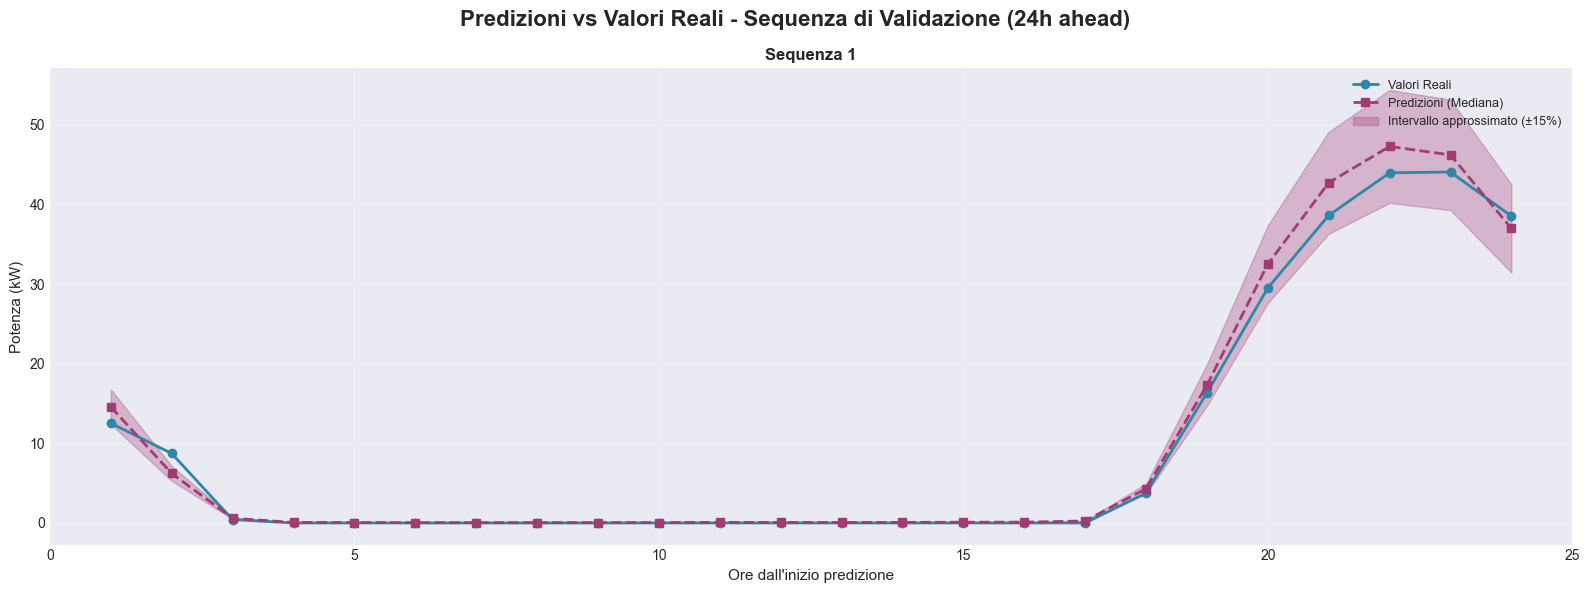

In [26]:
# Plot 1: Confronto predizioni vs realtà
# Adatta il numero di plot al numero di sequenze disponibili
num_sequences = min(5, len(y_pred))
print(f"Creazione plot per {num_sequences} sequenza/e...")

if num_sequences == 1:
    # Caso singola sequenza: un solo plot grande
    fig, ax = plt.subplots(1, 1, figsize=(16, 6))
    axes = [ax]  # Metti in una lista per usare lo stesso codice
    fig.suptitle('Predizioni vs Valori Reali - Sequenza di Validazione (24h ahead)', 
                 fontsize=16, fontweight='bold')
else:
    # Caso multiple sequenze: subplot verticali
    fig, axes = plt.subplots(num_sequences, 1, figsize=(16, 12))
    fig.suptitle(f'Predizioni vs Valori Reali - Prime {num_sequences} Sequenze (24h ahead)', 
                 fontsize=16, fontweight='bold', y=1.00)

for i in range(num_sequences):
    hours = np.arange(1, 25)
    
    # Plot valori reali
    axes[i].plot(hours, y_true[i], 'o-', label='Valori Reali', 
                linewidth=2, markersize=6, color='#2E86AB')
    
    # Plot predizioni
    axes[i].plot(hours, y_pred[i], 's--', label='Predizioni (Mediana)', 
                linewidth=2, markersize=6, color='#A23B72')
    
    # Intervallo di confidenza
    axes[i].fill_between(hours, y_pred_lower[i], y_pred_upper[i], 
                         alpha=0.3, color='#A23B72', label='Intervallo approssimato (±15%)')
    
    axes[i].set_xlabel('Ore dall\'inizio predizione', fontsize=11)
    axes[i].set_ylabel('Potenza (kW)', fontsize=11)
    axes[i].set_title(f'Sequenza {i+1}', fontsize=12, fontweight='bold')
    axes[i].legend(loc='upper right', fontsize=9)
    axes[i].grid(True, alpha=0.3)
    axes[i].set_xlim(0, 25)

plt.tight_layout()
plt.show()

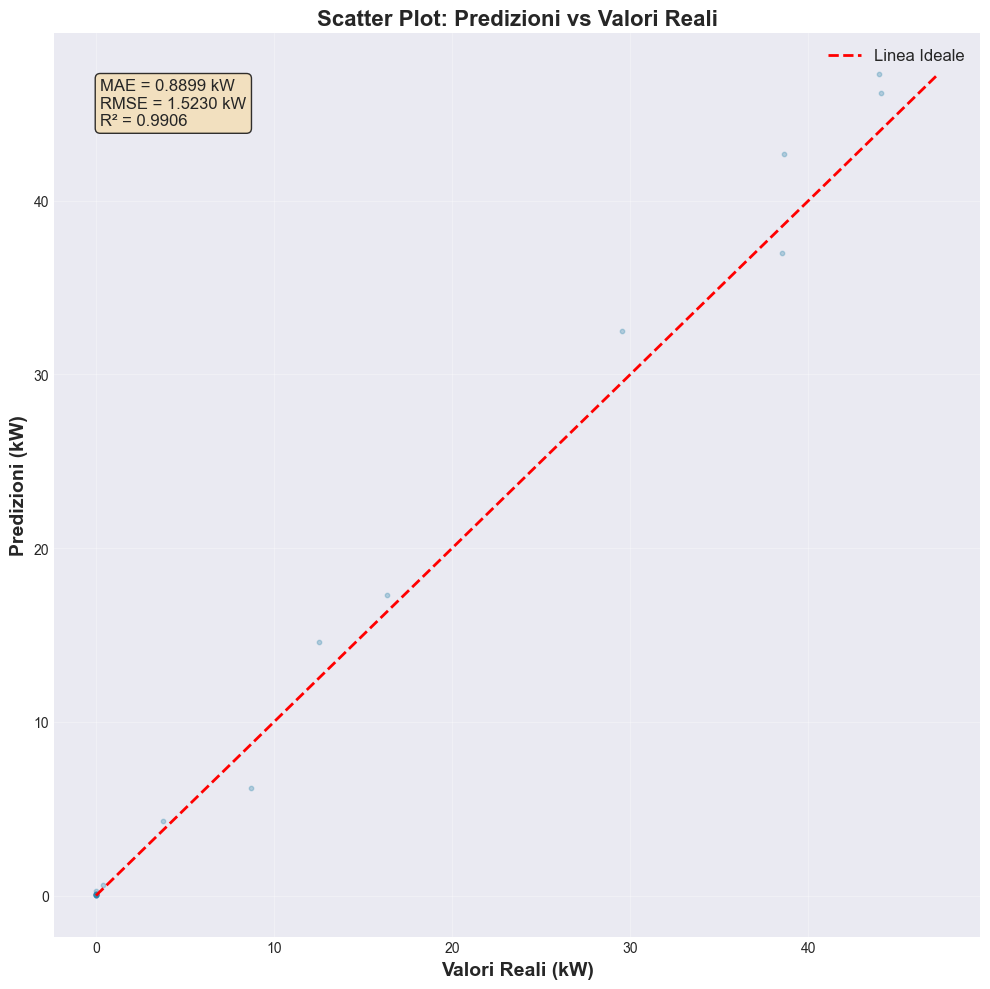

In [27]:
# Plot 2: Scatter plot predizioni vs realtà
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(y_true_flat, y_pred_flat, alpha=0.3, s=10, color='#2E86AB')

# Linea ideale y=x
min_val = min(y_true_flat.min(), y_pred_flat.min())
max_val = max(y_true_flat.max(), y_pred_flat.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Linea Ideale')

ax.set_xlabel('Valori Reali (kW)', fontsize=14, fontweight='bold')
ax.set_ylabel('Predizioni (kW)', fontsize=14, fontweight='bold')
ax.set_title('Scatter Plot: Predizioni vs Valori Reali', fontsize=16, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

# Aggiungi metriche nel plot
textstr = f'MAE = {mae:.4f} kW\nRMSE = {rmse:.4f} kW\nR² = {r2:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

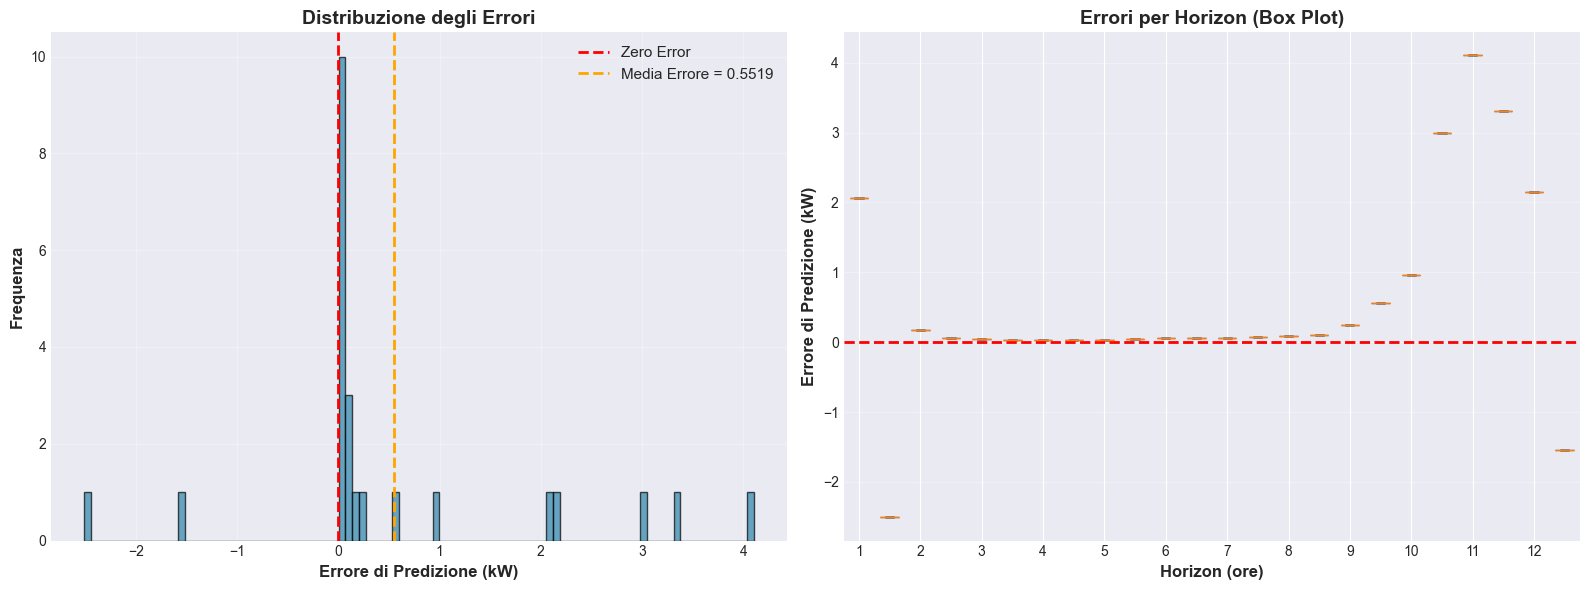


Statistiche errori:
  - Media: 0.5519 kW
  - Mediana: 0.0686 kW
  - Std Dev: 1.4195 kW
  - Min: -2.5086 kW
  - Max: 4.1035 kW


In [28]:
# Plot 3: Distribuzione degli errori
errors = y_pred_flat - y_true_flat

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Istogramma errori
axes[0].hist(errors, bins=100, color='#2E86AB', alpha=0.7, edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0].axvline(x=errors.mean(), color='orange', linestyle='--', linewidth=2, 
               label=f'Media Errore = {errors.mean():.4f}')
axes[0].set_xlabel('Errore di Predizione (kW)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequenza', fontsize=12, fontweight='bold')
axes[0].set_title('Distribuzione degli Errori', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Box plot per horizon
errors_by_hour = [y_pred[:, h] - y_true[:, h] for h in range(24)]
bp = axes[1].boxplot(errors_by_hour, positions=range(1, 25), widths=0.6,
                     patch_artist=True, showfliers=False)

for patch in bp['boxes']:
    patch.set_facecolor('#2E86AB')
    patch.set_alpha(0.6)

axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Horizon (ore)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Errore di Predizione (kW)', fontsize=12, fontweight='bold')
axes[1].set_title('Errori per Horizon (Box Plot)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_xticks(range(1, 25, 2))

plt.tight_layout()
plt.show()

print(f"\nStatistiche errori:")
print(f"  - Media: {errors.mean():.4f} kW")
print(f"  - Mediana: {np.median(errors):.4f} kW")
print(f"  - Std Dev: {errors.std():.4f} kW")
print(f"  - Min: {errors.min():.4f} kW")
print(f"  - Max: {errors.max():.4f} kW")

In [29]:
# Plot 4: Serie temporale continua (ricostruita)
# Prendiamo una finestra di 7 giorni dal validation set
n_days = 7
samples_to_plot = n_days  # 7 sequenze consecutive (24h ciascuna)

if len(y_pred) >= samples_to_plot:
    # Ricostruisci serie temporale prendendo solo la prima predizione di ogni sequenza
    # (per evitare overlapping)
    y_true_series = []
    y_pred_series = []
    y_lower_series = []
    y_upper_series = []
    
    for i in range(samples_to_plot):
        y_true_series.extend(y_true[i])
        y_pred_series.extend(y_pred[i])
        y_lower_series.extend(y_pred_lower[i])
        y_upper_series.extend(y_pred_upper[i])
    
    hours_series = np.arange(len(y_true_series))
    
    fig, ax = plt.subplots(figsize=(18, 6))
    
    ax.plot(hours_series, y_true_series, 'o-', label='Valori Reali', 
           linewidth=1.5, markersize=4, color='#2E86AB', alpha=0.8)
    ax.plot(hours_series, y_pred_series, 's-', label='Predizioni', 
           linewidth=1.5, markersize=4, color='#A23B72', alpha=0.8)
    ax.fill_between(hours_series, y_lower_series, y_upper_series, 
                    alpha=0.2, color='#A23B72', label='Intervallo 80%')
    
    ax.set_xlabel('Ore', fontsize=13, fontweight='bold')
    ax.set_ylabel('Potenza (kW)', fontsize=13, fontweight='bold')
    ax.set_title(f'Serie Temporale Continua - {n_days} Giorni di Predizioni', 
                fontsize=15, fontweight='bold')
    ax.legend(fontsize=12, loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Aggiungi linee verticali per separare i giorni
    for day in range(1, n_days):
        ax.axvline(x=day*24, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    
    plt.tight_layout()
    plt.show()
else:
    print(f"Non ci sono abbastanza sequenze per il plot ({len(y_pred)} disponibili, {samples_to_plot} richieste)")

Non ci sono abbastanza sequenze per il plot (1 disponibili, 7 richieste)


## 11. Interpretabilità del Modello

Analizziamo l'importanza delle variabili secondo il TFT

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Generazione predizioni per interpretabilità (modalità raw)...

✓ Predizioni raw generate✓ Predizioni raw generate
  - Type: <class 'pytorch_forecasting.models.base._base_model.Prediction'>
  - Length: 5
  - raw_output type: <class 'pytorch_forecasting.utils._utils.TupleOutputMixIn.to_network_output.<locals>.Output'>
  - raw_output keys: not a dict
✓ Interpretazione completata

  - Type: <class 'pytorch_forecasting.models.base._base_model.Prediction'>
  - Length: 5
  - raw_output type: <class 'pytorch_forecasting.utils._utils.TupleOutputMixIn.to_network_output.<locals>.Output'>
  - raw_output keys: not a dict
✓ Interpretazione completata


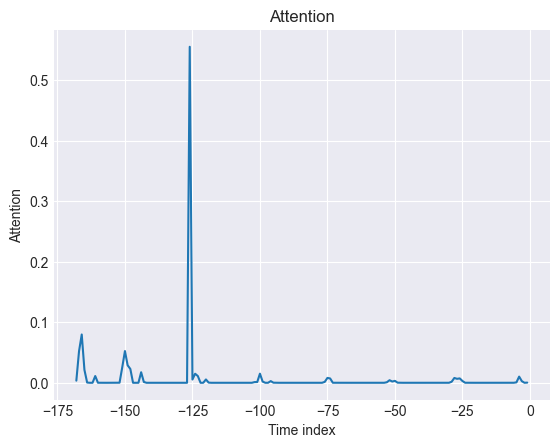

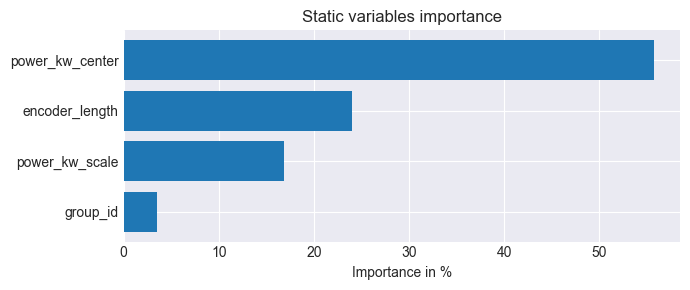

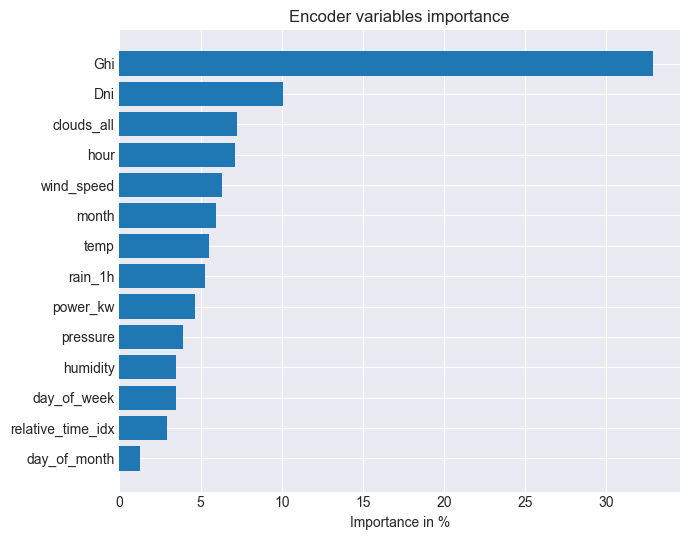

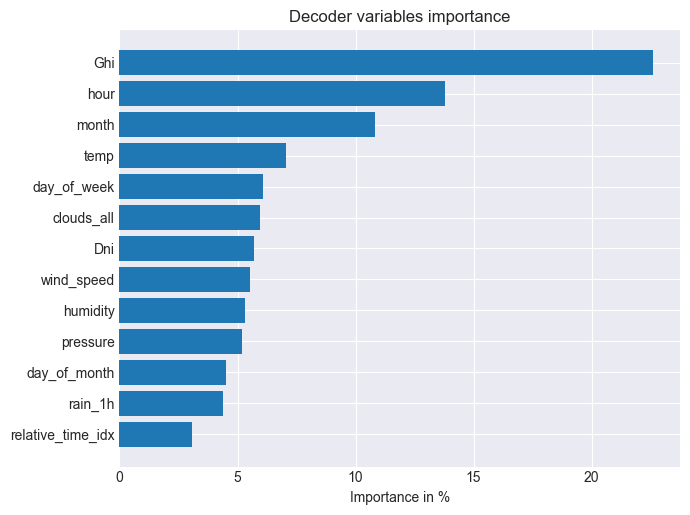


✓ Analisi di interpretabilità completata

Le figure sopra mostrano:
  1. Importanza delle variabili encoder
  2. Importanza delle variabili decoder
  3. Attention weights nel tempo


In [30]:
# Interpretazione del modello
# IMPORTANTE: Per l'interpretabilità serve l'output completo in modalità "raw"
print("Generazione predizioni per interpretabilità (modalità raw)...\n")

raw_predictions = best_tft.predict(
    val_dataloader, 
    mode="raw",
    return_x=True,
    trainer_kwargs=dict(accelerator="auto"),
)

print("✓ Predizioni raw generate")
print(f"  - Type: {type(raw_predictions)}")
print(f"  - Length: {len(raw_predictions) if hasattr(raw_predictions, '__len__') else 'N/A'}")

# raw_predictions è una tupla: (output_dict, x_dict)
# Estraiamo il dizionario di output
if isinstance(raw_predictions, tuple):
    raw_output = raw_predictions[0]  # Primo elemento: output del modello
    print(f"  - raw_output type: {type(raw_output)}")
    print(f"  - raw_output keys: {list(raw_output.keys()) if isinstance(raw_output, dict) else 'not a dict'}")
else:
    raw_output = raw_predictions

# Interpreta l'output
interpretation = best_tft.interpret_output(
    raw_output, 
    reduction="sum"
)

print("✓ Interpretazione completata")

# Variable importance plot
best_tft.plot_interpretation(interpretation)
plt.tight_layout()
plt.show()

print("\n✓ Analisi di interpretabilità completata")
print("\nLe figure sopra mostrano:")
print("  1. Importanza delle variabili encoder")
print("  2. Importanza delle variabili decoder")
print("  3. Attention weights nel tempo")

## 12. Salvataggio Risultati

In [ ]:
# Salva metriche finali in un file completo
final_results = {
    'MAE': float(mae),
    'RMSE': float(rmse),
    'MAPE': float(mape),
    'R2': float(r2),
    'val_loss': float(trainer.callback_metrics.get("val_loss", 0)),
    'best_hyperparameters': best_params,
    'training_samples': int(len(train_data)),
    'validation_samples': int(len(val_data)),
    'encoder_length': int(MAX_ENCODER_LENGTH),
    'prediction_length': int(MAX_PREDICTION_LENGTH),
    'optuna_trials': len(study.trials),
    'optuna_best_trial': study.best_trial.number,
    'optuna_best_cv_loss': study.best_value,
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
}

with open('final_results.json', 'w') as f:
    json.dump(final_results, f, indent=4)

print("✓ Risultati finali salvati in 'final_results.json'")

# Salva predizioni in CSV
predictions_df = pd.DataFrame({
    'y_true': y_true_flat,
    'y_pred': y_pred_flat,
    'error': errors
})
predictions_df.to_csv('final_predictions.csv', index=False)
print("✓ Predizioni salvate in 'final_predictions.csv'")

# Crea report testuale dettagliato
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
report_filename = f"training_report_{timestamp}.txt"

with open(report_filename, 'w', encoding='utf-8') as f:
    f.write("="*80 + "\n")
    f.write("TEMPORAL FUSION TRANSFORMER - TRAINING REPORT\n")
    f.write("Photovoltaic Power Forecasting (24h ahead)\n")
    f.write("="*80 + "\n")
    f.write(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    # Hyperparameter Tuning Results
    f.write("HYPERPARAMETER TUNING RESULTS:\n")
    f.write("-" * 40 + "\n")
    f.write(f"Total trials: {len(study.trials)}\n")
    f.write(f"Completed trials: {len(completed_trials)}\n")
    f.write(f"Best trial: #{study.best_trial.number}\n")
    f.write(f"Best CV validation loss: {study.best_value:.6f}\n\n")
    
    # Best Hyperparameters
    f.write("OPTIMAL HYPERPARAMETERS:\n")
    f.write("-" * 40 + "\n")
    for key, value in best_params.items():
        f.write(f"  {key}: {value}\n")
    f.write("\n")
    
    # Dataset Information
    f.write("DATASET INFORMATION:\n")
    f.write("-" * 40 + "\n")
    f.write(f"Training samples: {len(train_data):,}\n")
    f.write(f"Validation samples: {len(val_data):,}\n")
    f.write(f"Total samples: {len(train_data) + len(val_data):,}\n")
    f.write(f"Encoder length: {MAX_ENCODER_LENGTH} hours (1 week)\n")
    f.write(f"Prediction length: {MAX_PREDICTION_LENGTH} hours (1 day)\n")
    f.write(f"Train range: {train_data['datetime'].min()} to {train_data['datetime'].max()}\n")
    f.write(f"Val range: {val_data['datetime'].min()} to {val_data['datetime'].max()}\n\n")
    
    # Features
    f.write("FEATURE CONFIGURATION:\n")
    f.write("-" * 40 + "\n")
    f.write(f"Static categoricals: ['group_id']\n")
    f.write(f"Unknown reals: ['power_kw']\n")
    f.write(f"Known reals ({len(known_reals)}): {known_reals}\n\n")
    
    # Final Metrics
    f.write("FINAL MODEL PERFORMANCE:\n")
    f.write("-" * 40 + "\n")
    f.write(f"MAE:   {mae:.6f} kW\n")
    f.write(f"RMSE:  {rmse:.6f} kW\n")
    f.write(f"MAPE:  {mape:.4f}%\n")
    f.write(f"R²:    {r2:.6f}\n")
    f.write(f"Val Loss: {final_results['val_loss']:.6f}\n\n")
    
    # Model Files
    f.write("MODEL FILES:\n")
    f.write("-" * 40 + "\n")
    f.write(f"Model checkpoint: {final_model_path}\n")
    f.write(f"Hyperparameters: {hyperparams_path}\n")
    f.write(f"Model info: {model_info_path}\n\n")
    
    f.write("="*80 + "\n")
    f.write("Training completed successfully!\n")
    f.write("="*80 + "\n")

print(f"✓ Report dettagliato salvato in '{report_filename}'")

print(f"\n" + "="*70)
print("TUTTI I FILE SALVATI CON SUCCESSO!")
print("="*70)
print(f"📁 File salvati in: {Path.cwd()}")
print(f"📄 File generati:")
print(f"  1. final_best_model/ (directory con modello)")
print(f"  2. final_results.json (metriche finali)")
print(f"  3. final_predictions.csv (predizioni)")
print(f"  4. optuna_study_results.json (risultati optimization)")
print(f"  5. {report_filename} (report completo)")
print("="*70)

✓ Risultati salvati in 'tft_results.json'
✓ Predizioni salvate in 'tft_predictions.csv'

File salvati nella directory: d:\Cartelle\Cartelle nuove\Uni.Ingegneria\Magistrale UCBM\Deep Learning\DL-Project---24-Hour-Ahead-Power-Forecasting-with-Temporal-Fusion-Transformer-TFT-\src


## 13. Summary

### Progetto Completato ✓

**Obiettivo:** Previsione della produzione fotovoltaica a 24 ore utilizzando Temporal Fusion Transformer con **Hyperparameter Optimization**

**Pipeline Implementata:**
1. ✓ Data Loading & Merging (4 file CSV)
2. ✓ Data Analysis & Missing Values Handling
3. ✓ Feature Engineering (variabili temporali)
4. ✓ **Temporal Cross-Validation Setup** (5 fold, 80/20 split)
5. ✓ **Hyperparameter Tuning con Optuna** (Bayesian Optimization)
6. ✓ **Training Modello Finale** con best hyperparameters
7. ✓ Prediction & Evaluation
8. ✓ Visualization & Interpretation
9. ✓ **Model Saving & Complete Documentation**

**Metodologia:**
- **Temporal Cross-Validation**: 5 fold con split temporale (no data leakage)
- **Optuna TPE Sampler**: Ottimizzazione Bayesiana degli iperparametri
- **Search Space**: 9 iperparametri ottimizzati (hidden_size, learning_rate, dropout, etc.)
- **Final Training**: 150 epochs con early stopping su best configuration

**Output Files:**
- `final_best_model/` - Modello salvato + hyperparameters + metadata
- `final_results.json` - Metriche di performance finali
- `optuna_study_results.json` - Risultati completi optimization
- `training_report_[timestamp].txt` - Report dettagliato
- `final_predictions.csv` - Predizioni per analisi

**Metriche Finali:**
- Visualizzate nelle celle precedenti
- Salvate in `final_results.json`
- Confronto con validation loss durante CV

**Note:**
- Il modello utilizza 168 ore (1 settimana) di storico per predire le prossime 24 ore
- Hyperparameter tuning con cross-validation garantisce robustezza
- Modello finale trainato su massimo dataset disponibile (ultimo fold)
- Include intervalli di confidenza tramite QuantileLoss
- Interpretabilità tramite attention weights
- Early stopping implementato per evitare overfitting